In [1]:
import time
import warnings
from pathlib import Path
import jsonpickle
import jsonpickle.ext.numpy as jsonpickle_numpy
jsonpickle_numpy.register_handlers()
import numpy as np
import scipy
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo
import os
resources_path = os.path.normpath(os.path.join(os.getcwd(), "dr7run6_te62fnal001_qoc_qctrl/waveforms"))

plt.style.use(qv.get_qctrl_style())

# Disable warning from qiskit.
warnings.filterwarnings("ignore")

In [2]:
# Read and write helper functions, type independent.
def save_variable(file_name, var):
    """
    Save a single variable to a file using jsonpickle.
    """
    with open(file_name, "w+") as file:
        file.write(jsonpickle.encode(var))


def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r+") as file:
        return jsonpickle.decode(file.read())

two_pi = 2 * np.pi

def get_time():
    return " "+time.strftime(r'%Y-%m-%d %H-%M-%S',time.localtime())

# Flag to read long optimization results from files.

In [3]:
# Parameters.
giga = 1e9
mega = 1e6
nano = 1e-9

colors = {
    "Q-CTRL": qv.QCTRL_STYLE_COLORS[0],
    "Amplitude robust": qv.QCTRL_STYLE_COLORS[0],
    "Square": qv.QCTRL_STYLE_COLORS[1],
    "IBM default X-gate": qv.QCTRL_STYLE_COLORS[2],
}

bloch_colors = {
    "x": qv.QCTRL_STYLE_COLORS[0],
    "y": qv.QCTRL_STYLE_COLORS[1],
    "z": qv.QCTRL_STYLE_COLORS[2],
}
bloch_markers = {"x": "x", "y": "s", "z": "o"}
bloch_lines = {"x": "--", "y": "-.", "z": "-"}
bloch_basis = ["x", "y", "z"]

In [4]:
X_gate = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=complex)
X90_gate = np.array([[1.0, -1j], [-1j, 1.0]], dtype=complex) / np.sqrt(2)
Y90_gate = np.array([[1.0, -1], [1.0, 1.0]], dtype=complex) / np.sqrt(2)
X90n_gate = np.array([[-1j, 1.0], [1.0, -1j]], dtype=complex) / np.sqrt(2)
Y90n_gate = np.array([[1.0, 1.0], [-1.0, 1.0]], dtype=complex) / np.sqrt(2)

In [5]:
number_of_segments = {}
number_of_optimization_variables = {}
cutoff_frequency = {}
segment_scale = {}
duration_int = {}
duration = {}

scheme_names = ["Q-CTRL"]
rabi_rotation = np.pi
number_of_runs = 200
omega_max = 2 * np.pi * 55e6 * np.sqrt(2)
I_max = omega_max / np.sqrt(2)
Q_max = omega_max / np.sqrt(2)

pluse_duration = 20 * nano
dt = 1 * nano

# Dephasing-robust pulse parameters.
number_of_optimization_variables["Q-CTRL"] = 20
number_of_segments["Q-CTRL"] = int(pluse_duration / dt)
segment_scale["Q-CTRL"] = 1
cutoff_frequency["Q-CTRL"] = 1000 * mega
duration["Q-CTRL"] = number_of_segments["Q-CTRL"] * segment_scale["Q-CTRL"] * dt
print("duration: ",duration["Q-CTRL"] * 1e9)

duration:  20.0


In [6]:
graph = bo.Graph()

In [7]:
I_values = graph.optimization_variable(
        count=number_of_optimization_variables["Q-CTRL"],
        lower_bound=-I_max,
        upper_bound=I_max,
    )
Q_values = graph.optimization_variable(
    count=number_of_optimization_variables["Q-CTRL"],
    lower_bound=-Q_max,
    upper_bound=Q_max,
)

In [8]:
# Anchor ends to zero with amplitude rise/fall envelope.
time_points = np.linspace(
    -1.0, 1.0, number_of_optimization_variables["Q-CTRL"] + 2
)[1:-1]
envelope_function = 1.0 - np.abs(time_points)
envelope_function = envelope_function - envelope_function[0]
I_values = I_values * envelope_function
Q_values = Q_values * envelope_function

In [9]:
# Create I & Q signals.
I_signal = graph.pwc_signal(values=I_values, duration=duration["Q-CTRL"])
Q_signal = graph.pwc_signal(values=Q_values, duration=duration["Q-CTRL"])

In [10]:
# Apply the sinc filter and re-discretize signals.
I_signal = graph.filter_and_resample_pwc(
    pwc=I_signal,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency["Q-CTRL"]),
    segment_count=number_of_segments["Q-CTRL"],
    name="I",
)
Q_signal = graph.filter_and_resample_pwc(
    pwc=Q_signal,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency["Q-CTRL"]),
    segment_count=number_of_segments["Q-CTRL"],
    name="Q",
)

In [11]:
# Create Hamiltonian control terms.
I_term = I_signal * graph.pauli_matrix("X") / 2.0
Q_term = Q_signal * graph.pauli_matrix("Y") / 2.0

control_hamiltonian = I_term + Q_term

In [12]:
# Create dephasing noise term.
dephasing = graph.constant_pwc_operator(
    duration=duration["Q-CTRL"],
    operator=graph.pauli_matrix("Z") / 2.0 / duration["Q-CTRL"],
)

In [13]:
 # Create infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=control_hamiltonian,
    target=graph.target(Y90n_gate),
    name="infidelity",
)

In [14]:
result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    noise_operators=[dephasing],
    output_node_names=["I", "Q"],
    optimization_count=40,
)

Your task (action_id="2044066") is queued.
Your task (action_id="2044066") has completed.


In [15]:
print(f"Cost: {result['cost']}")
robust_dephasing_controls = {}
robust_dephasing_controls["Q-CTRL"] = result["output"]

Cost: 5.773159728050814e-15


In [16]:
result

{'cost': 5.773159728050814e-15,
 'output': {'I': {'values': array([ 3.27345985e+07,  4.82590370e+07,  2.43315734e+07, -3.49554468e+07,
          -9.64444472e+07, -1.17578798e+08, -7.60689222e+07,  1.18404569e+07,
           9.89150253e+07,  1.36314970e+08,  1.04750258e+08,  2.58119177e+07,
          -5.38240974e+07, -9.33060422e+07, -8.16905512e+07, -3.96543499e+07,
          -3.68043955e+05,  1.44815068e+07,  6.14914601e+06, -8.14945146e+06]),
   'durations': array([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
          1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
          1.e-09, 1.e-09, 1.e-09, 1.e-09]),
   'time_dimension': 0},
  'Q': {'values': array([ 1.38886404e+07,  2.85211678e+07,  2.74620781e+07,  5.88502566e+05,
          -5.10542724e+07, -1.14724695e+08, -1.72257532e+08, -2.09024691e+08,
          -2.19931561e+08, -2.09261870e+08, -1.85622531e+08, -1.56275147e+08,
          -1.24705357e+08, -9.21107167e+07, -6.03355863e+07, -3.30977258

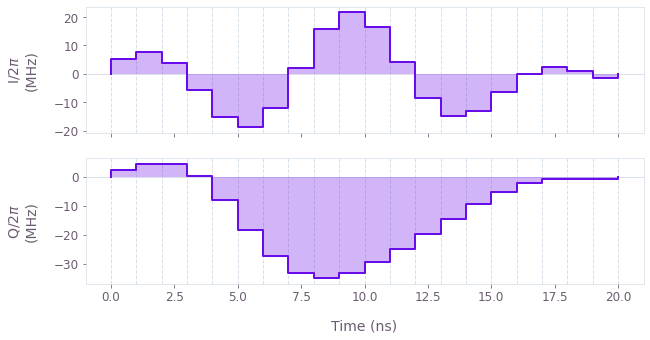

In [17]:
qv.plot_controls(robust_dephasing_controls["Q-CTRL"])

In [18]:
fname = "qoc_y_pi2n_20ns"
save_variable(resources_path+"/"+fname, result)